In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import pickle
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input, VGG19

2023-03-21 21:18:52.735949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 21:18:53.910758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-03-21 21:18:53.910921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-03-21 21:18

# The Model

We decided to use the VGG19 model trained on imagenet.

In [17]:
DATA_DIR = "data/ILSVRC2012_img_val"
GROUND_TRUTH = "data/ground_truth.txt"
PICKLE_DIR = "pickles"
MAPPING_DATA = "data/devkit/data/map_clsloc.txt"
file_names = os.listdir(DATA_DIR)
READ_FROM_PICKLE = False
file_names.sort()

In [8]:
def read_images(file_names, data_dir):
    images = []
    i = 0
    for file_name in file_names:
        i += 1
        if i % 1000 == 0:
            print("Read {} images".format(i))
        file_path = os.path.join(data_dir, file_name)
        image = Image.open(file_path)
        image = image.resize((224, 224))
        image = np.array(image)
        if len(image.shape) != 3:
            image = np.stack((image,)*3, axis=-1)
        if image.shape[2] == 4:
            image = image[:,:,:3]
        # image = preprocess_input(image)
        images.append(image)
    return images

if not READ_FROM_PICKLE:
    images = read_images(file_names, DATA_DIR)
    # for i in range(len(images)):
    #     # make sure each image has 3 channels
    #     if len(images[i].shape) != 3:
    #         images[i] = np.stack((images[i],)*3, axis=-1)
    #     if images[i].shape[2] == 4:
    #         images[i] = images[i][:,:,:3]
    images = np.array(images)
    with open(os.path.join(PICKLE_DIR, "images.pickle"), "wb") as f:
        pickle.dump(images, f)
else:
    with open(os.path.join(PICKLE_DIR, "images.pickle"), "rb") as f:
        images = pickle.load(f)

Read 1000 images
Read 2000 images
Read 3000 images
Read 4000 images
Read 5000 images
Read 6000 images
Read 7000 images
Read 8000 images
Read 9000 images
Read 10000 images
Read 11000 images
Read 12000 images
Read 13000 images
Read 14000 images
Read 15000 images
Read 16000 images
Read 17000 images
Read 18000 images
Read 19000 images
Read 20000 images
Read 21000 images
Read 22000 images
Read 23000 images
Read 24000 images
Read 25000 images
Read 26000 images
Read 27000 images
Read 28000 images
Read 29000 images
Read 30000 images
Read 31000 images
Read 32000 images
Read 33000 images
Read 34000 images
Read 35000 images
Read 36000 images
Read 37000 images
Read 38000 images
Read 39000 images
Read 40000 images
Read 41000 images
Read 42000 images
Read 43000 images
Read 44000 images
Read 45000 images
Read 46000 images
Read 47000 images
Read 48000 images
Read 49000 images
Read 50000 images


In [9]:
labels = pd.read_csv(GROUND_TRUTH, sep=" ", header=None).to_numpy()

In [10]:
vgg_model = tf.keras.applications.VGG19(weights='imagenet', input_shape=(224, 224, 3))
vgg_model.summary()

2023-03-21 21:22:42.226358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 21:22:42.261394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 21:22:42.261597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 21:22:42.262511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Classify a couple examples:

In [55]:
mapping = pd.read_csv(MAPPING_DATA, delimiter=" ", header=None, names=['code', 'id', 'name'])

In [56]:
labels_df = pd.DataFrame(labels)
labels_df.columns = ["id"]


In [52]:
merged_df = pd.merge(mapping, labels_df, on='id', how="right")

In [57]:
merged_df

,code,id,name
0,n01751748,490,sea_snake
1,n09193705,361,alp
2,n02105855,171,Shetland_sheepdog
3,n04263257,822,soup_bowl
4,n03125729,297,cradle
...,...,...,...
49995,n02123394,10,Persian_cat
49996,n01630670,495,common_newt
49997,n02106166,128,Border_collie
49998,n10148035,848,groom


# Classifying

In [11]:
y_hat = vgg_model.predict(images[:15])

2023-03-21 21:22:44.626996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-21 21:22:45.399023: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-21 21:22:45.399852: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-03-21 21:22:45.399861: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-03-21 21:22:45.399897: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

1/1 [==============================] - 6s 6s/step


2023-03-21 21:22:49.759255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
y_hat = decode_predictions(y_hat, top=5)

AttributeError: 'list' object has no attribute 'shape'

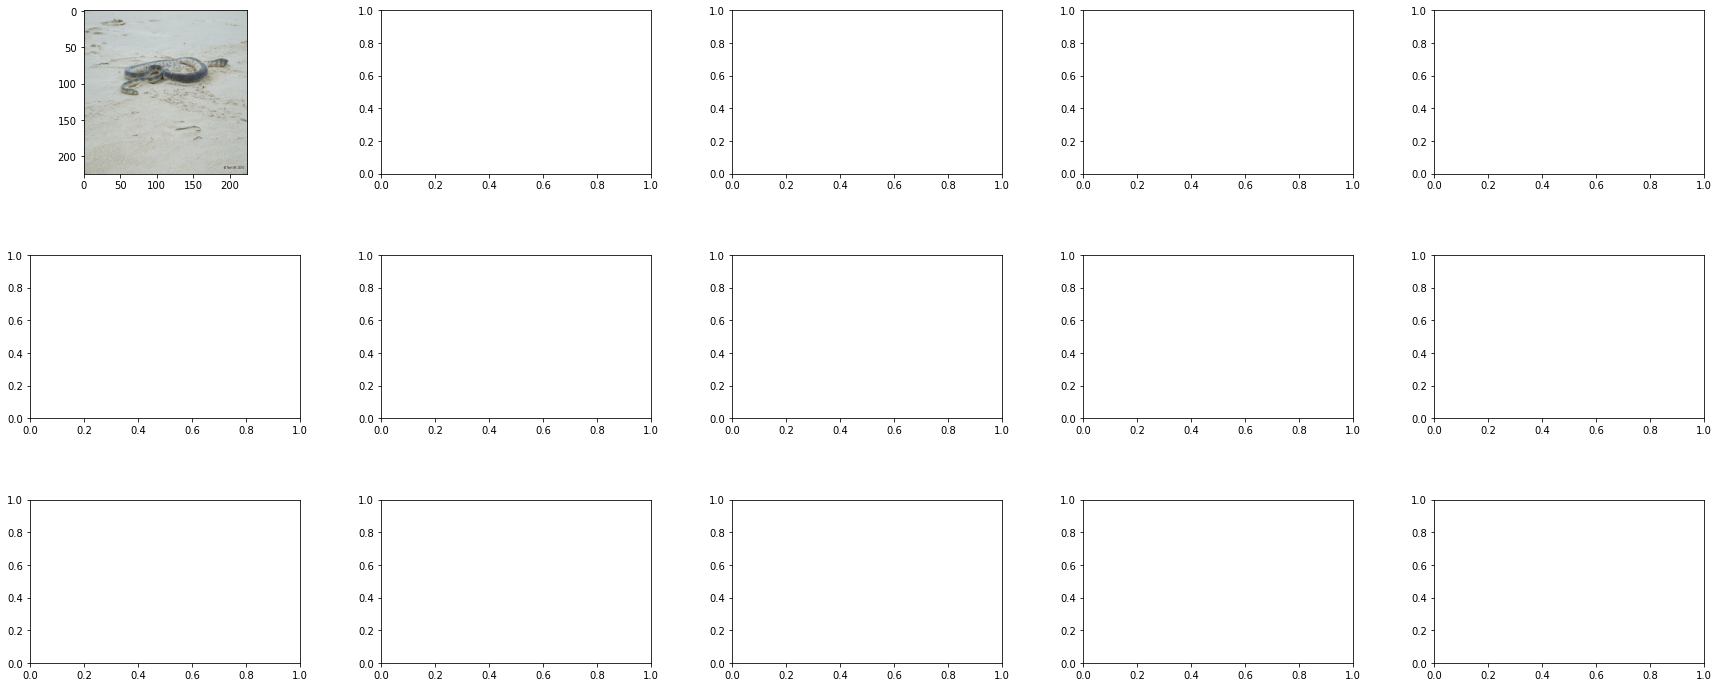

In [13]:
# GENERATED BY GPT
fig, axs = plt.subplots(3, 5, figsize=(30, 12), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
for i in range(15):
    ax = axs[i//5, i%5]
    ax.imshow(images[i])
    ax.set_title(decode_predictions(y_hat, top=1)[i][0][1])
    ax.axis("off")
plt.show()


These classifications seem to be working decently, obviously some are wrong but the model itself seems to be classifying to some degree as intended.

# Chosing a Filter


conv5_1 unit 474

In [25]:
# get the conv5_1 layer
conv5_1 = vgg_model.get_layer("block5_conv1")

In [33]:
target_filter = conv5_1.get_weights()[0].shape

(3, 3, 512, 512)